# Trash Segregation project

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2025-07-31 07:53:22.995090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 07:53:23.095462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753948403.119664     503 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753948403.127115     503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 07:53:23.209123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Getting data ready

In [3]:
import os

In [4]:
unique_labels=os.listdir("images/")
len(unique_labels)

30

In [5]:
images={}
for i in unique_labels:
    for j in os.listdir("images/"+i+"/default/"):
        if(j[-1]=='g'):
            images[i+'/default/'+j]=i
    for j in os.listdir("images/"+i+"/real_world/"):
        if(j[-1]=='g'):
            images[i+'/real_world/'+j]=i

images["aerosol_cans/default/Image_1.png"]

'aerosol_cans'

In [6]:
len(images)

15000

In [7]:
filenames=[]
for file in images.keys():
    filenames.append("images/"+file)
filenames[12000]

labels=[]
for label in images.values():
    labels.append(label)
labels[12000]

'styrofoam_food_containers'

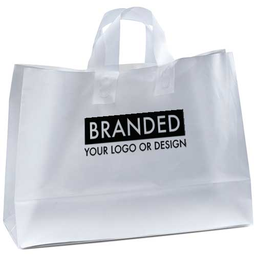

In [10]:
from IPython.display import Image
Image(filename=filenames[6969])

In [11]:
labels[6969]

'plastic_shopping_bags'

In [8]:
labels=np.array(labels)
len(labels)

15000

In [9]:
unique_labels=np.unique(labels)
len(unique_labels)

30

In [14]:
bool_label=labels[6969]==unique_labels

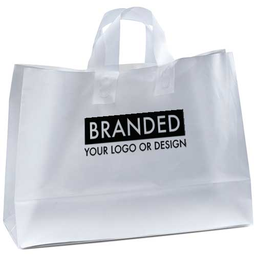

In [15]:
Image(filenames[6969])

In [16]:
unique_labels[np.argmax(bool_label)]

np.str_('plastic_shopping_bags')

In [84]:
#Converting into boolean labels
def create_bool_labels(labels):
    bool_labels=[]
    for label in labels:
        bool_labels.append(label==unique_labels)
    return bool_labels
bool_labels=create_bool_labels(labels)
len(bool_labels)

15000

In [11]:
unique_labels[bool_labels[6969].argmax()]

np.str_('plastic_shopping_bags')

In [12]:
def get_label(y):
    return unique_labels[y.argmax()]

# Splitting Data into train, validation and test splits

In [13]:
x=filenames
y=bool_labels
len(x),len(y)

(15000, 15000)

In [68]:
0.6*15000

9000.0

In [69]:
0.2*15000

3000.0

In [105]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x[:1000],
                                             y[:1000],
                                             test_size=0.2,
                                             shuffle=True)
len(x_train),len(x_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [106]:
x_train[750],get_label(y_train[750])

('images/styrofoam_cups/default/Image_151.png', np.str_('styrofoam_cups'))

# Preprocess images and turn into batches

In [114]:
# Creating a generalised function that does this

#define image size
IMG_SIZE=299

def process_image(image_path):
  #Read the file
  image=tf.io.read_file(image_path)

  #Turn the image into tensor with 3 channels(RGB)
  image=tf.image.decode_jpeg(image,channels=3)

  #Convert the colour channels to (0,1)
  # image=tf.image.convert_image_dtype(image,tf.float32)

  #Resize the image to (224,224)
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

In [15]:
#Creating a function to return a Tensor Tuples
def create_tuples(image_path,label):
  image=process_image(image_path)
  return image,label

#Creating a function that return data batches
BATCH_SIZE=32
def create_batches(x,y=None,batch_size=BATCH_SIZE,valid_set=False,test_set=False):
  if test_set:
    print("Creating test data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x))) #Only for x as no labels for test set
    data=data.map(process_image)
    data_batch=data.batch(batch_size)
    return data_batch
  elif valid_set:
    print("Creating valid set batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.map(create_tuples)
    data_batch=data.batch(batch_size)
    return data_batch
  else:
    print("Creating training set batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.shuffle(buffer_size=len(x))
    data=data.map(create_tuples)
    data_batch=data.batch(batch_size)
  return data_batch

In [110]:
train_batch=create_batches(x_train,y_train)
val_batch=create_batches(x_val,y_val,valid_set=True)

Creating training set batches...
Creating valid set batches...


In [111]:
train_batch.element_spec,val_batch.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 30), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 30), dtype=tf.bool, name=None)))

# Create and train a model

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [114]:
# Set image size and number of classes
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 30

# Load pre-trained InceptionV3 base
base_model = tf.keras.applications.InceptionV3(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Phase 1: Freeze base model

In [115]:
# Classifier head with GlobalAveragePooling
classifier_head = Sequential([
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(NUM_CLASSES, activation='softmax')
])

In [116]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name="data_augmentation")

In [117]:
# Assemble the full model
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    data_augmentation,
    base_model,
    classifier_head
])

/home/saksham/miniconda3/envs/gpu-final/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [118]:
# Compile for Phase 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

In [120]:
# TRAINING PHASE 1
print("=== Phase 1: Training classifier head ===")
history1 = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

=== Phase 1: Training classifier head ===
Epoch 1/20


I0000 00:00:1753871308.436575  163124 cuda_dnn.cc:529] Loaded cuDNN version 91001


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 464ms/step - accuracy: 0.4833 - loss: 2.2818 - val_accuracy: 0.9300 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9550 - loss: 0.2821 - val_accuracy: 0.9400 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9750 - loss: 0.1593 - val_accuracy: 0.9600 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.9788 - loss: 0.1188 - val_accuracy: 0.9650 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9726 - loss: 0.1174 - val_accuracy: 0.9600 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9852 - loss: 0.0705
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9851 - loss: 0.0707 - val_accura

In [122]:
# UNFREEZE top layers of base model for fine-tuning
print("=== Phase 2: Fine-tuning base model ===")
base_model.trainable = True

# Optionally: freeze all layers except top 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# TRAINING PHASE 2
history2 = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

=== Phase 2: Fine-tuning base model ===
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.9777 - loss: 0.1569 - val_accuracy: 0.9650 - val_loss: 0.1818 - learning_rate: 1.0000e-05
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.9876 - loss: 0.0876 - val_accuracy: 0.9700 - val_loss: 0.1631 - learning_rate: 1.0000e-05
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.9913 - loss: 0.0687 - val_accuracy: 0.9650 - val_loss: 0.1629 - learning_rate: 1.0000e-05
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.9789 - loss: 0.1050 - val_accuracy: 0.9650 - val_loss: 0.1547 - learning_rate: 1.0000e-05
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.9941 - loss: 0.0423 - val_accuracy: 0.9700 - val_loss: 0.1534 - learning_rate: 1.0000e-05
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.9887 - loss: 0.0670 - val_accuracy: 0.9650 - val_loss: 0.1451 - learning_rate: 1.0000e-05
Epoch 7/20
25/25 ━━━━━━

In [123]:
model.evaluate(val_batch)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9828 - loss: 0.0715


[0.07389546185731888, 0.9800000190734863]

# Saving and loading a model

In [135]:
import datetime
def save_model(model,suffix=None):
    #Create a directory path for our model in the models folder
    modeldir=os.path.join("trash-segregation/models/",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path=modeldir+"-"+suffix+".h5"
    print("Saving model to path ",model_path,"...")
    model.save(model_path)
    return model_path

In [17]:
def load_model(model_path):
  print("Loading saved model from path ",model_path,"...")
  model=tf.keras.models.load_model(model_path,
                                   custom_objects={"KerasLayer":hub.KerasLayer})
  return model

# Training the model on all images

In [18]:
len(x),len(y)

(15000, 15000)

In [115]:
#Splitting into training and testing sets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.25)
# test_df=pd.read_csv("test_data_split_3000_images.csv")
# x_test=test_df["x_test"]
# y_test=test_df["y_test"]

In [116]:
len(x_train),len(y_train),len(x_val),len(y_val),len(x_test),len(y_test)

(9000, 9000, 3000, 3000, 3000, 3000)

In [78]:
y_test_labels=test_df["y_test"].map(get_label)

In [79]:
y_test_labels

0                       paper_cups
1                         clothing
2        glass_cosmetic_containers
3          plastic_food_containers
4               plastic_trash_bags
                   ...            
2995               steel_food_cans
2996                styrofoam_cups
2997               cardboard_boxes
2998     glass_cosmetic_containers
2999    disposable_plastic_cutlery
Name: y_test, Length: 3000, dtype: object

In [96]:
test_df=pd.DataFrame(data={"x_test":x_test,"y_test":y_test})
test_df.head()

x_test  \
0  images/glass_cosmetic_containers/real_world/Im...   
1  images/plastic_shopping_bags/real_world/Image_...   
2  images/plastic_shopping_bags/real_world/Image_...   
3  images/aluminum_food_cans/real_world/Image_233...   
4       images/office_paper/real_world/Image_189.png   

                                              y_test  
0  [False, False, False, False, False, False, Fal...  
1  [False, False, False, False, False, False, Fal...  
2  [False, False, False, False, False, False, Fal...  
3  [False, True, False, False, False, False, Fals...  
4  [False, False, False, False, False, False, Fal...

In [81]:
test_df["y_test"][0]

np.str_('paper_cups')

In [117]:
test_df=pd.read_csv("test_data_split_3000_images_labels.csv")
test_df.head()

Unnamed: 0                                             x_test  \
0           0          images/paper_cups/real_world/Image_55.png   
1           1              images/clothing/default/Image_187.png   
2           2  images/glass_cosmetic_containers/real_world/Im...   
3           3  images/plastic_food_containers/real_world/Imag...   
4           4     images/plastic_trash_bags/default/Image_40.png   

                      y_test  
0                 paper_cups  
1                   clothing  
2  glass_cosmetic_containers  
3    plastic_food_containers  
4         plastic_trash_bags

In [118]:
y_labels=list(test_df["y_test"])
len(y_labels)

3000

In [143]:
y_test=create_bool_labels(y_labels)
y_test

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, Fa

In [120]:
y_test[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [121]:
train_batch=create_batches(x_train,y_train)
val_batch=create_batches(x_val,y_val,valid_set=True)
test_batch=create_batches(x_test,y_test,valid_set=True)

Creating training set batches...
Creating valid set batches...
Creating valid set batches...


In [122]:
test_batch

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30), dtype=tf.bool, name=None))>

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [124]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_fn(img, label):
    return preprocess_input(img), label

train_batch = train_batch.map(preprocess_fn)
val_batch = val_batch.map(preprocess_fn)
test_batch = test_batch.map(preprocess_fn)

In [125]:
# Set image size and number of classes
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 30

# Load pre-trained InceptionV3 base
base_model = tf.keras.applications.InceptionV3(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Phase 1: Freeze base model

In [126]:
# Classifier head with GlobalAveragePooling
classifier_head = Sequential([
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(NUM_CLASSES, activation='softmax')
])

In [127]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name="data_augmentation")

In [128]:
# Assemble the full model
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    data_augmentation,
    base_model,
    classifier_head
])

/home/saksham/miniconda3/envs/gpu-final/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [131]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=100 * (len(x_train) // BATCH_SIZE)
)

# Re-compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

In [132]:
# TRAINING PHASE 1
print("=== Phase 1: Training classifier head ===")
history1 = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=100,
    callbacks=[early_stopping]
)

=== Phase 1: Training classifier head ===
Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - accuracy: 0.7143 - loss: 0.9140 - val_accuracy: 0.7643 - val_loss: 0.7483
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 52s 183ms/step - accuracy: 0.7175 - loss: 0.8971 - val_accuracy: 0.7660 - val_loss: 0.7305
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.7130 - loss: 0.9150 - val_accuracy: 0.7710 - val_loss: 0.7197
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 55s 193ms/step - accuracy: 0.7371 - loss: 0.8494 - val_accuracy: 0.7710 - val_loss: 0.7090
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 79s 184ms/step - accuracy: 0.7349 - loss: 0.8389 - val_accuracy: 0.7713 - val_loss: 0.7041
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.7281 - loss: 0.8537 - val_accuracy: 0.7750 - val_loss: 0.6986
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.7466 - loss: 0.8264 - val_accuracy: 0.7750 - val_loss: 0.6931
Epoch 8/100
282/282 ━━━━━━━━━━━━━━

In [133]:
# UNFREEZE top layers of base model for fine-tuning
print("=== Phase 2: Fine-tuning base model ===")
base_model.trainable = True

# Optionally: freeze all layers except top 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=100 * (len(x_train) // BATCH_SIZE)
)

# Re-compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# TRAINING PHASE 2
history2 = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

=== Phase 2: Fine-tuning base model ===
Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 88s 257ms/step - accuracy: 0.7386 - loss: 0.8279 - val_accuracy: 0.7897 - val_loss: 0.6660 - learning_rate: 9.9975e-06
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 240ms/step - accuracy: 0.7763 - loss: 0.7143 - val_accuracy: 0.7963 - val_loss: 0.6448 - learning_rate: 9.9901e-06
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 240ms/step - accuracy: 0.7633 - loss: 0.7091 - val_accuracy: 0.8013 - val_loss: 0.6230 - learning_rate: 9.9777e-06
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 237ms/step - accuracy: 0.7898 - loss: 0.6653 - val_accuracy: 0.8057 - val_loss: 0.6011 - learning_rate: 9.9603e-06
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 241ms/step - accuracy: 0.8058 - loss: 0.6050 - val_accuracy: 0.8070 - val_loss: 0.5926 - learning_rate: 9.9380e-06
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 242ms/step - accuracy: 0.8065 - loss: 0.6024 - val_accuracy: 0.8090 - val_loss: 0.5770 - learning_rate: 9.9108e-06
Epoch 

In [146]:
path=save_model(model,"inception_v3-full-image-set-3")

Saving model to path  trash-segregation/models/20250731-12051753963551-inception_v3-full-image-set-3.h5 ...


In [144]:
# TRAINING PHASE 2
history2 = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 233ms/step - accuracy: 0.9356 - loss: 0.2098 - val_accuracy: 0.8460 - val_loss: 0.4847
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 242ms/step - accuracy: 0.9337 - loss: 0.2124 - val_accuracy: 0.8460 - val_loss: 0.4901
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 235ms/step - accuracy: 0.9332 - loss: 0.2068 - val_accuracy: 0.8483 - val_loss: 0.4907
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 69s 244ms/step - accuracy: 0.9377 - loss: 0.1994 - val_accuracy: 0.8467 - val_loss: 0.4882


In [145]:
model.evaluate(val_batch)

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8386 - loss: 0.5041


[0.48467007279396057, 0.8460000157356262]

In [153]:
# --- Step 1: Load the test data ONCE ---
# Do this in one cell and do not run it again.
test_df = pd.read_csv("test_data_split_3000_images_labels.csv")

# --- Step 2: Extract paths and labels FROM THE SAME DATAFRAME ---
# This guarantees x_test_paths[i] corresponds to y_test_labels[i]
x_test_paths = test_df["x_test"].tolist()
y_test_labels_string = test_df["y_test"].tolist()

# --- Step 3: Create your one-hot encoded labels ---
# Using your 'create_bool_labels' function (or similar one-hot encoding method)
y_test_encoded = create_bool_labels(y_test_labels_string)

# --- Step 4: Create the test batch with the now-aligned data ---
# Your create_batches function
test_batch = create_batches(x_test_paths, y_test_encoded, valid_set=True)

# --- Step 5: Preprocess the batch ---
# Your preprocess function for InceptionV3
def preprocess_fn(img, label):
    return preprocess_input(img), label

test_batch = test_batch.map(preprocess_fn)

# --- Step 6: Evaluate the model ---
# This will now give you an accurate result.
loss, accuracy = model.evaluate(test_batch)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Creating valid set batches...
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9048 - loss: 0.2886
Test Accuracy: 90.73%


In [157]:
loaded_model=load_model("trash-segregation/models/20250731-11011753959669-inception_v3-full-image-set-1.h5")
loaded_model.evaluate(test_batch)

Loading saved model from path  trash-segregation/models/20250731-11011753959669-inception_v3-full-image-set-1.h5 ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.8883 - loss: 0.3488


[0.33636197447776794, 0.8893333077430725]

# Evaluating the model

In [163]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_probs = model.predict(test_batch)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([np.argmax(label, axis=1) for _, label in test_batch])

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step


2025-07-31 12:29:43.785162: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [164]:
len(y_pred),len(y_true)

(3000, 3000)

In [165]:
len(unique_labels)

30

In [166]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score, recall_score,confusion_matrix

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       102
           1       0.66      0.59      0.62        85
           2       0.89      0.87      0.88       107
           3       0.69      0.66      0.68        92
           4       0.71      0.74      0.72       112
           5       0.95      0.95      0.95        85
           6       0.97      0.99      0.98       104
           7       0.99      0.96      0.97       119
           8       0.99      0.99      0.99        95
           9       1.00      1.00      1.00        86
          10       0.92      0.92      0.92       107
          11       0.94      0.94      0.94       108
          12       0.96      0.96      0.96       100
          13       0.98      0.94      0.96        90
          14       0.91      0.94      0.93        89
          15       0.92      0.89      0.91       104
          16       0.88      0.96      0.92       127
          17       0.95    

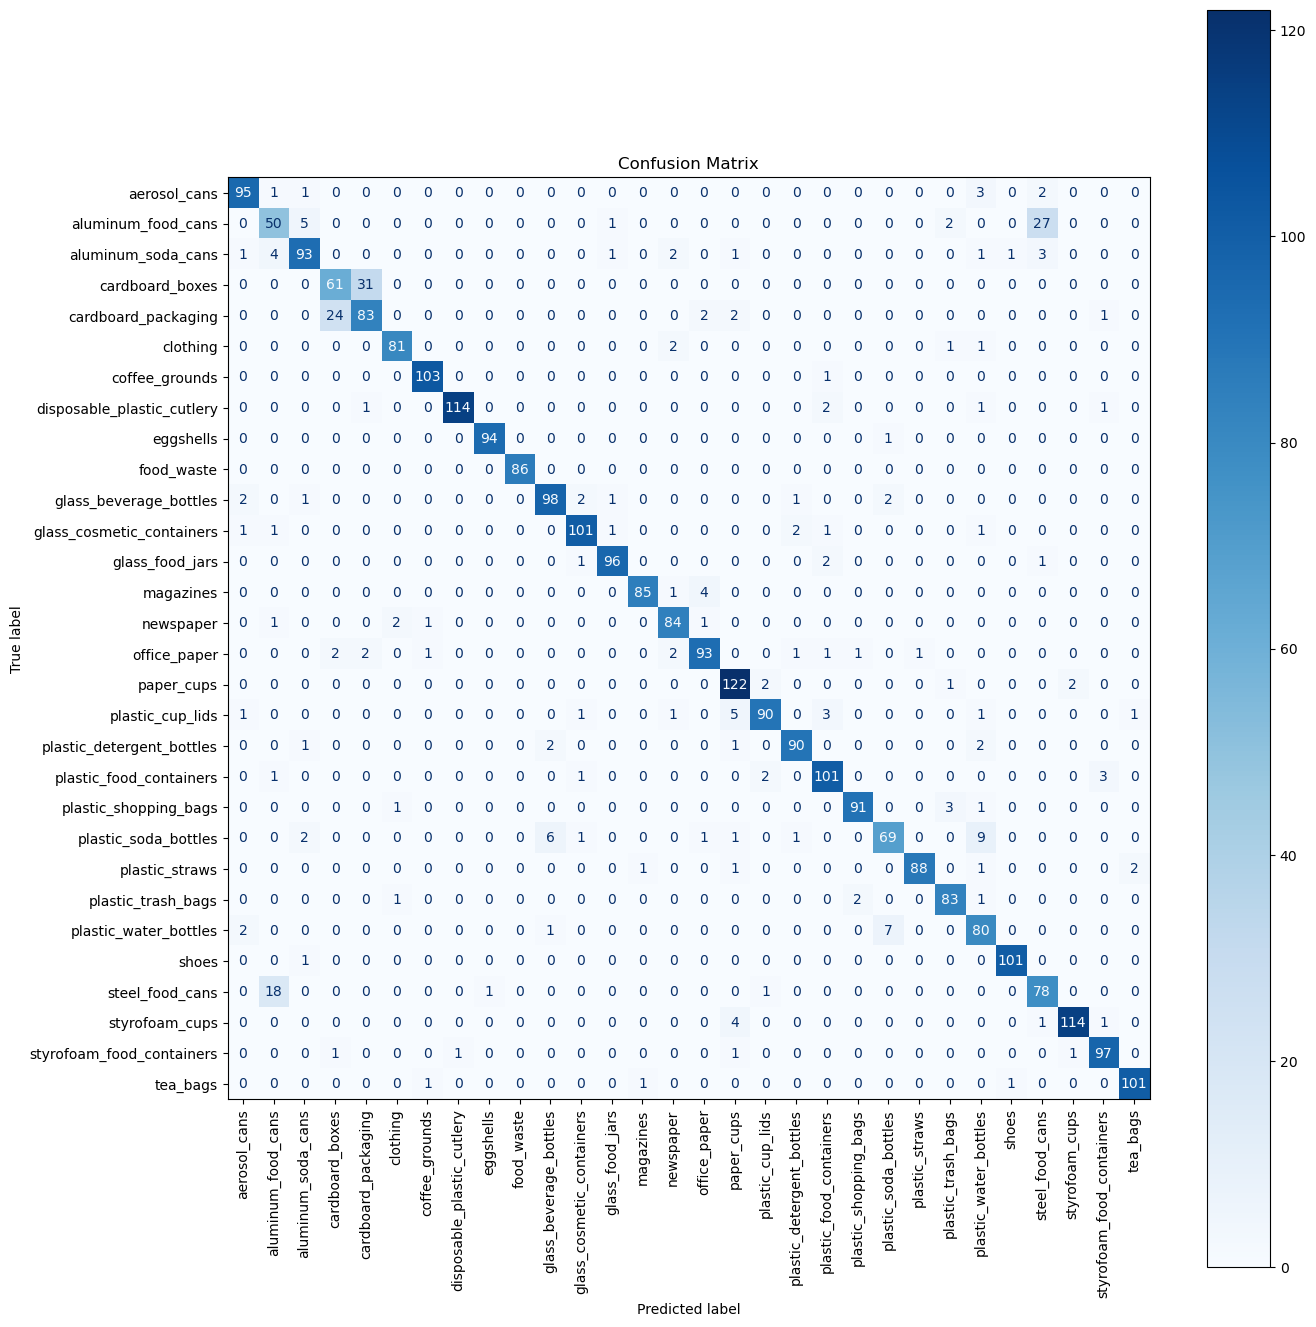

In [167]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [168]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')  # or 'weighted'
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9073
Precision: 0.9071
Recall:    0.9052
F1 Score:  0.9055
